In [38]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm

In [39]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
bw = 0.01 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi
difference_in_method_error = 0.002 # 2 keV - error estimated from the choice of gauss fitting instead of peak finding using SearchHighRes()

In [40]:
E = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id==2)"):
    E=np.append(E, ak.flatten(batch.E))
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==2)"):
    E2p=np.append(E2p, ak.flatten(batch.E))

In [41]:

def cal_error(energy):
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U3.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U3.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < 1000:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if np.any(bad_E == energy) or energy>np.max(bad_E):
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U3calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U3.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    
    cals = np.loadtxt(setup_path+"U3EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_x = (2*energy - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_x/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_x/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_x * front_err[i][2]) + \
                            (0.5 * uncal_x * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    
    return np.sqrt(total_variance/counter)/1e3





def pcal_error(fedep,bedep):
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U3.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U3.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < 1000:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if fedep+bedep < np.max(bad_E)*0.95:
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U3calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U3.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    padcal_errs = np.loadtxt("P3calerrors.dat")
    padcal = np.loadtxt(setup_path+"P3EE.cal")
    cals = np.loadtxt(setup_path+"U3EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_fedep = (2*fedep - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_fedep/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_fedep/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_fedep * front_err[i][2]) + \
                            (0.5 * uncal_fedep * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    uncal_bedep = (bedep-padcal[0])/padcal[1]
    pad_var = (uncal_bedep**2 * padcal_errs[1]**2)+padcal_errs[0]**2
    return np.sqrt(total_variance/counter+pad_var)/1e3



In [42]:
####Helper function and function definitions used to fit and plot
# Two function to use for fitting, one that estimates the background a long with fitting the gauss and one that has a specified background between the first and last bin


def gausslin(x, a, x0, sigma, s, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + s*x+c
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def counter(E, x_low, x_up, quiet=False, yscale='log'):
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low,x_up+bw,bw))
    counts = np.sum(ys)*scale
    counts_err = np.sqrt(np.sum(ys))*scale
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Counted region: {x_low}-{x_up}")
    return counts, counts_err

def GaussArea(x_low,x_up,mu,sigma):
    return norm.cdf(x_up, loc=mu, scale=sigma) - norm.cdf(x_low, loc=mu, scale=sigma)
    
def GaussArea_error(x_low, x_up, mu, sigma, err_mu, err_sigma, cov_mu_sigma=0.0):
    pdf_x1 = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x2 = norm.pdf(x_up, loc=mu, scale=sigma)
    df_dmu = pdf_x1 - pdf_x2

    df_dsigma = ((x_low - mu) / sigma) * pdf_x1 - ((x_up - mu) / sigma) * pdf_x2

    variance = (df_dmu**2 * err_mu**2) + \
               (df_dsigma**2 * err_sigma**2) + \
               (2 * df_dmu * df_dsigma * cov_mu_sigma)
               
    return np.sqrt(variance)


def FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac,
                          popt, pcov, x_low, x_up, bw):
    a, mu, sigma = popt[0], popt[1], popt[2]

    df_da = (sigma * np.sqrt(2 * np.pi)) / bw
    df_dsigma = (a * np.sqrt(2 * np.pi)) / bw

    pdf_x_low = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x_up = norm.pdf(x_up, loc=mu, scale=sigma)
    
    dg_dmu = pdf_x_low - pdf_x_up
    dg_dsigma = ((x_low - mu) / sigma) * pdf_x_low - ((x_up - mu) / sigma) * pdf_x_up

  #Covariance between N and Nfrac
    cov_N_Nfrac = (df_da * dg_dmu * pcov[0, 1]) + \
                  (df_da * dg_dsigma * pcov[0, 2]) + \
                  (df_dsigma * dg_dmu * pcov[2, 1]) + \
                  (df_dsigma * dg_dsigma * pcov[2, 2])
    
    final_product = N * N_frac
    
    if final_product == 0:
        return 0.0

    relative_variance = (uncertainty_N / N)**2 + \
                        (uncertainty_N_frac / N_frac)**2 + \
                        2 * cov_N_Nfrac / (N * N_frac)

    if relative_variance < 0:
        relative_variance = 0

    final_error = abs(final_product) * np.sqrt(relative_variance)
    
    return final_error


def fixedlin_fit(E, x_low, x_up, gamma=0, quiet=False, yscale='log'):
     
    
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    x_bg = np.concatenate((xs[:1], xs[-1:]))
    y_bg = np.concatenate((ys[:1], ys[-1:]))

    s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

    func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = 0.02
    p0_final = [a_guess, x0_guess, sigma_guess]

    lower_bounds_final = [0, xs[0], 0]
    upper_bounds_final = [np.inf, xs[-1], np.inf]
    bounds_final = (lower_bounds_final, upper_bounds_final)

    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf

    popt_final, pcov_final = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=errors,bounds=bounds_final)

    final_parameters = [popt_final[0], popt_final[1], popt_final[2], s_fit, c_fit]

    var_mean = pcov_final[1,1]
    mean = popt_final[1]
    
    N = (popt_final[0]*popt_final[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov_final[0,0])/popt_final[0])**2 + (np.sqrt(pcov_final[2,2])/popt_final[2])**2 + 2* pcov_final[0,2] / (popt_final[0]*popt_final[2]))
    
    N_frac = GaussArea(x_low,x_up, popt_final[1],popt_final[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt_final[1], popt_final[2], np.sqrt(pcov_final[1,1]), np.sqrt(pcov_final[2,2]), pcov_final[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt_final, pcov_final, x_low, x_up, bw)
    
    N_background = np.sum(s_fit * xs + c_fit)
    x1, x2 = x_bg[0], x_bg[1]
    y1, y2 = y_bg[0], y_bg[1]
    var_y1 = y1
    var_y2 = y2
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    dx = x2 - x1
    dN_dy1 = (x2 * len_xs - sum_xs) / dx
    dN_dy2 = (sum_xs - x1 * len_xs) / dx
    var_N_background = (dN_dy1**2 * var_y1) + (dN_dy2**2 * var_y2)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N_peak + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N_peak**2 + uncertainty_N_background**2)

    xlin = np.linspace(xs[0]-bw*5, xs[-1]+5*bw, 200)


    try:
        calerr = cal_error(mean * 1e3)
    except ValueError:
        calerr = 5 / 1e3
    error = np.sqrt(var_mean+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    
    if not quiet:
        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N_peak:.2f} ± {uncertainty_N_peak:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")
        print("="*50)
        print()
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.3,x_up+0.3+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.plot(xlin, gausslin(xlin, *final_parameters), 'b-', label='Final Fit')
        plt.plot(xlin, s_fit * xlin + c_fit, 'g--', label='Background')

        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit in range {x_low}-{x_up} + linear background taken from highest and lowest bin")
        
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': final_parameters,
        'covariance_matrix': pcov_final,

    }
    
    # --- ADDED LINE: Returning the results dictionary ---
    return results

def standard_fit(E, x_low, x_up, a_lowerbound=-np.inf, gamma=0, quiet=False, yscale='log'):
    

    # --- MODIFIED LINE: The histogram for the actual fitting process now uses x_low and x_up ---
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = (xs[-1] - xs[0]) * 0.1
    s_guess = 10
    c_guess = -100
    p0 = [a_guess, x0_guess, sigma_guess, s_guess, c_guess]
    lower_bounds = [0, xs[0], 0, a_lowerbound, -np.inf]
    upper_bounds = [np.inf, xs[-1], np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf
    popt, pcov = curve_fit(gausslin,xs,ys,p0=p0,sigma=errors,bounds=bounds,absolute_sigma=True)

    # --- MODIFIED LINE: The plotting range for the fit line is now +- 0.6 from x_low and x_up ---
    xlin = np.linspace(x_low - 5*bw, x_up + 5*bw, 200)

    
    N = (popt[0]*popt[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov[0,0])/popt[0])**2 + (np.sqrt(pcov[2,2])/popt[2])**2 + 2* pcov[0,2] / (popt[0]*popt[2]))
    
    N_frac = GaussArea(x_low,x_up, popt[1],popt[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt[1], popt[2], np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), pcov[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt, pcov, x_low, x_up, bw)
    
    
    var_mean = pcov[1,1]
    mean = popt[1]

    N_background = np.sum(popt[3] * xs + popt[4])
    var_s = pcov[3, 3]
    var_c = pcov[4, 4]
    cov_s_c = pcov[3, 4]
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    var_N_background = (sum_xs**2 * var_s) + (len_xs**2 * var_c) + (2 * sum_xs * len_xs * cov_s_c)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N**2 + uncertainty_N_background**2)
    
    try:
        calerr = cal_error(mean * 1e3)
    except ValueError:
        calerr = 5 / 1e3
    error = np.sqrt(var_mean+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.plot(xlin, gausslin(xlin, popt[0], popt[1], popt[2], popt[3], popt[4]),'b-')

        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N:.2f} ± {uncertainty_N:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")        
        plt.yscale(yscale)
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit+linear background in range {x_low}-{x_up}")
        print("="*50)
        print()
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': popt,
        'covariance_matrix': pcov
    }
    return results


--- Fit Values---
Peak Mean:                     1.167 ± 0.002
22Mg excited level energy:     8.444 ± 0.002
Peak Counts:                   128.57 ± 8.42
Background Counts:             504.00 ± 42.00
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 632.57 ± 42.84

--- Fit Values---
Peak Mean:                     1.315 ± 0.002
22Mg excited level energy:     6.883 ± 0.002
Peak Counts:                   213.03 ± 9.84
Background Counts:             675.00 ± 45.00
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 888.03 ± 46.06

--- Fit Values---
Peak Mean:                     1.251 ± 0.002
22Mg excited level energy:     7.147 ± 0.002
Peak Counts:                   7385.76 ± 225.69
Background Counts:             1001.98 ± 199.12
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 8387.74 ± 300.98

128.56551430982978 139.71478502631734
Total main peak counts

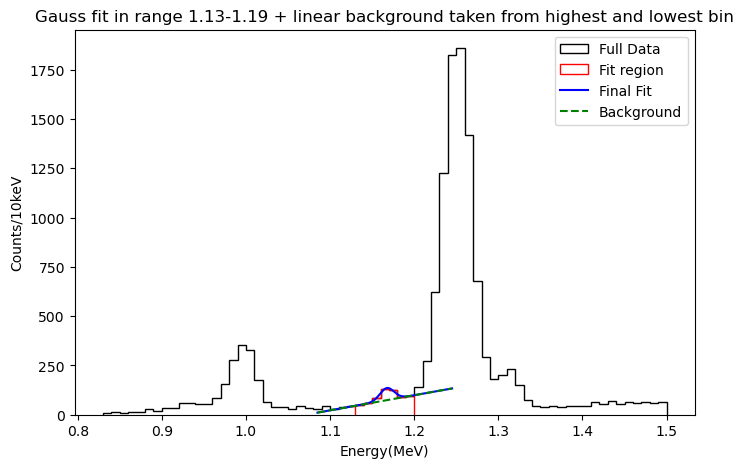

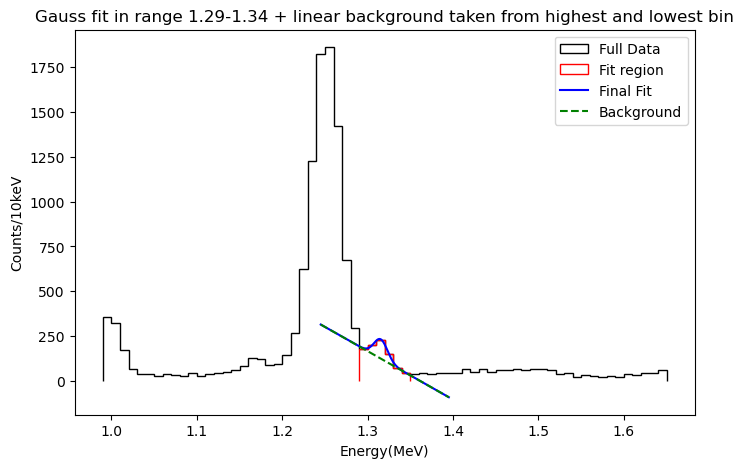

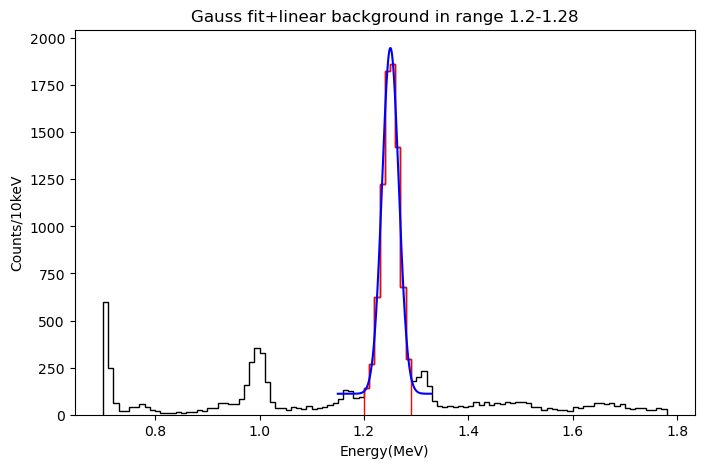

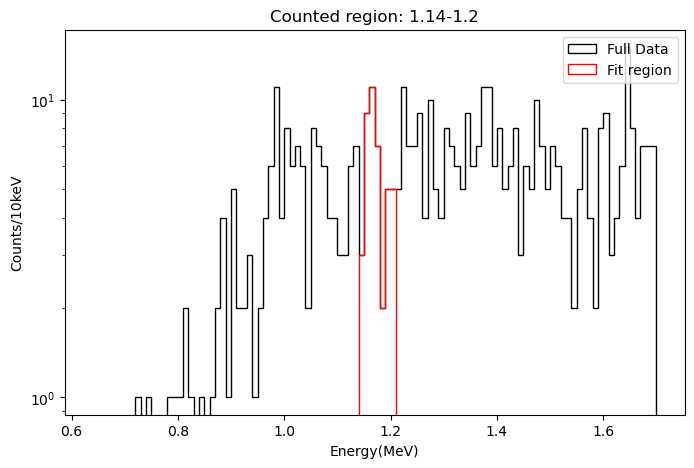

In [44]:
leftsat = fixedlin_fit(E, 1.13,1.19, gamma=2, quiet=False, yscale='linear')
rightsat = fixedlin_fit(E, 1.29,1.34, gamma=0, quiet=False, yscale='linear')
main = standard_fit(E, 1.20, 1.28, a_lowerbound=0, gamma=1, quiet=False, yscale='linear')


leftsat_2p, leftsat_2p_err = counter(E2p, 1.14,1.20, quiet=False)
rightsat_2p, rightsat_2p_err = counter(E2p, 1.29,1.34, quiet=True)
main_2p, main_2p_err = counter(E2p, 1.21,1.28, quiet=True, yscale='linear')

leftsat_counts = leftsat['peak_counts']-leftsat_2p
print(leftsat['peak_counts'],leftsat_2p)
leftsat_counts_err = np.sqrt(leftsat['peak_counts_uncertainty']**2+leftsat_2p_err**2)
rightsat_counts = rightsat['peak_counts']-rightsat_2p
rightsat_counts_err = np.sqrt(rightsat['peak_counts_uncertainty']**2+rightsat_2p_err**2)
main_counts = main['total_fitted_counts']+leftsat['background_counts']+rightsat['background_counts']-main_2p
main_counts_err = np.sqrt(main['total_fitted_uncertainty']**2+leftsat['background_counts_uncertainty']**2+rightsat['background_counts_uncertainty']**2+
                          +main_2p_err**2)
print(f"Total main peak counts corrected for 2p and satelite backgrounds: {main_counts:.0f} ± {main_counts_err:.0f} counts")
print(f"Total left satelite peak counts corrected for 2p: {leftsat_counts:.0f} ± {leftsat_counts_err:.0f} counts")
print(f"Total right satelite peak counts corrected for 2p: {rightsat_counts:.0f} ± {rightsat_counts_err:.0f} counts")
print()
print("="*100)
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {main['mean']:.3f} ± {main['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {main['truepeak']:.3f} ± {main['truepeak_uncertainty']:.3f}")
print()
print(f"left peak:")
print(f"Proton energies:            {leftsat['mean']:.3f} ± {leftsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {leftsat['truepeak']:.3f} ± {leftsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right peak:")
print(f"Proton energies:            {rightsat['mean']:.3f} ± {rightsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat['truepeak']:.3f} ± {rightsat['truepeak_uncertainty']:.3f}")
print()

--- Fit Values---
Peak Mean:                     1.850 ± 0.002
22Mg excited level energy:     7.775 ± 0.002
Peak Counts:                   121.71 ± 5.52
Background Counts:             234.50 ± 28.65
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 356.21 ± 29.18

non-twoproton events counts: 160 ± 39
twoproton events counts: 196 ± 26
Fitted means for the peaks and their true value

Main peak:
Proton energies:            1.850 ± 0.002
22Mg excitedstate energies: 7.775 ± 0.002


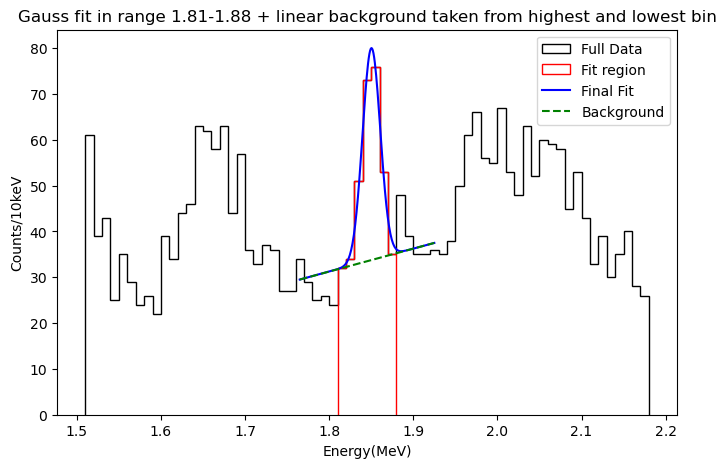

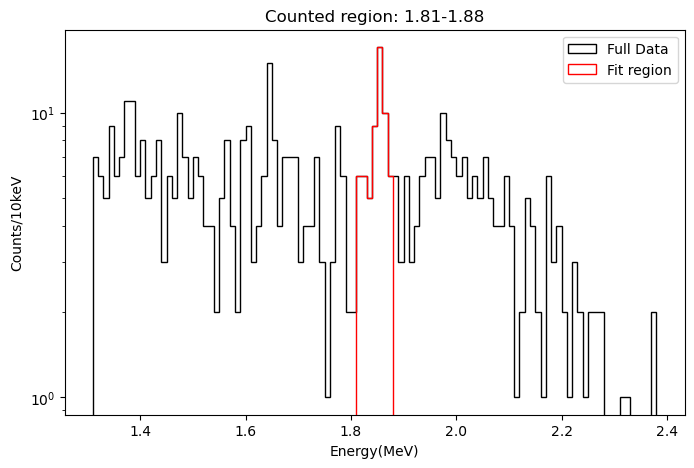

In [45]:
fourth = fixedlin_fit(E, 1.81, 1.88, gamma=1, quiet=False, yscale='linear')
c2p, err = counter(E2p, 1.81,1.88, quiet=False)
c = fourth['total_fitted_counts']-c2p
c_err = np.sqrt(fourth['total_fitted_uncertainty']**2+err**2)
print(f"non-twoproton events counts: {c:.0f} ± {c_err:.0f}")
print(f"twoproton events counts: {c2p:.0f} ± {err:.0f}")
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {fourth['mean']:.3f} ± {fourth['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {fourth['truepeak']:.3f} ± {fourth['truepeak_uncertainty']:.3f}")

--- Fit Values---
Peak Mean:                     5.466 ± 0.006
22Mg excited level energy:     14.061 ± 0.006
Peak Counts:                   53.08 ± 13.02
Background Counts:             144.00 ± 29.39
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 197.08 ± 32.15

--- Fit Values---
Peak Mean:                     3.870 ± 0.006
22Mg excited level energy:     9.892 ± 0.007
Peak Counts:                   106.24 ± 15.78
Background Counts:             247.00 ± 40.07
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 353.24 ± 43.06


Peak in range 3.84-3.92:
Total counts sub 2p 343.26 ± 43.45



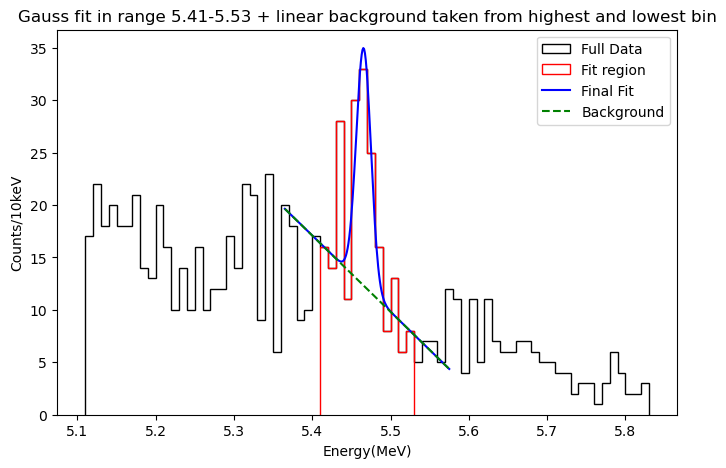

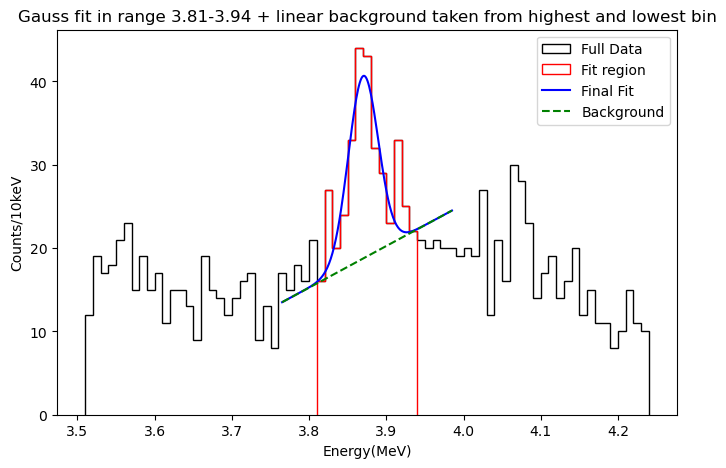

In [46]:
main = fixedlin_fit(E, 5.41, 5.53, gamma=3, quiet=False, yscale='linear')
main2 = fixedlin_fit(E, 3.81,3.94, gamma=1, yscale='linear')#, a_lowerbound=0)
main2_c, main2_c_err = counter(E2p, 3.84,3.92, yscale='linear', quiet=True)#, a_lowerbound=0)
main_counts = main2['total_fitted_counts']-main2_c
main_counts_err = np.sqrt(main2['total_fitted_uncertainty']**2+main2_c_err**2)
print("="*100)
print()
print(f"Peak in range 3.84-3.92:")
print(f"Total counts sub 2p {main_counts:.2f} ± {main_counts_err:.2f}")

print()

--- Fit Values---
Peak Mean:                     6.530 ± 0.011
22Mg excited level energy:     14.063 ± 0.011
Peak Counts:                   93.03 ± 83.17
Background Counts:             78.86 ± 72.67
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 171.88 ± 110.44

--- Fit Values---
Peak Mean:                     7.852 ± 0.020
22Mg excited level energy:     14.065 ± 0.021
Peak Counts:                   23.29 ± 78.23
Background Counts:             38.87 ± 66.12
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 62.16 ± 102.42



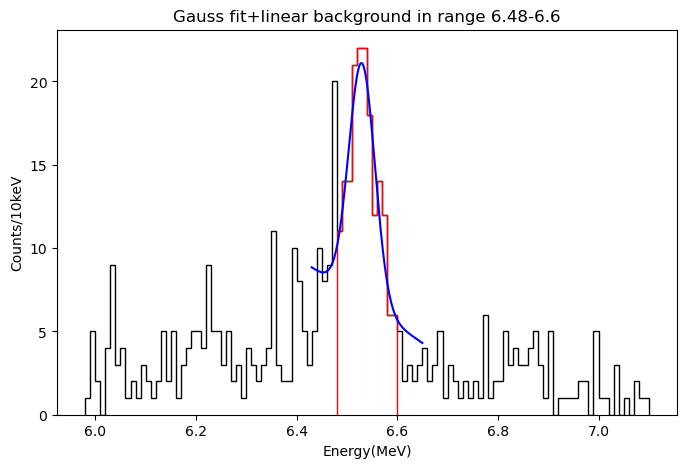

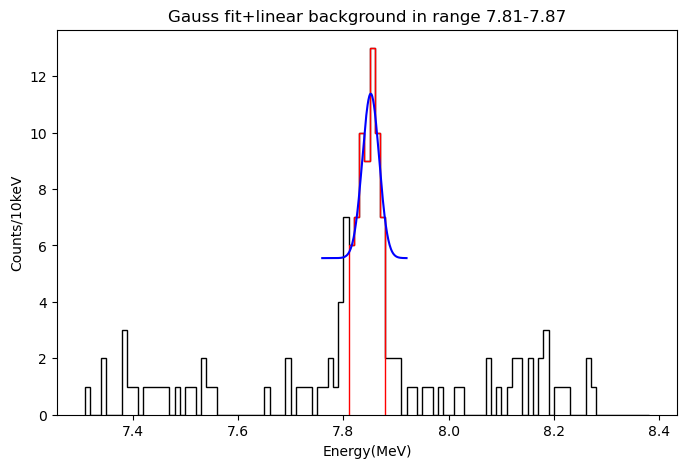

In [37]:
# overlapping satellite peak -> not usable for gaussian determination!


main = standard_fit(E, 6.48, 6.6, gamma=2, quiet=False, yscale='linear')

main2 = standard_fit(E, 7.81, 7.87, gamma=1,a_lowerbound=0, quiet=False, yscale='linear')

--- Fit Values---
Peak Mean:                     0.996 ± 0.002
22Mg excited level energy:     6.880 ± 0.002
Peak Counts:                   1115.20 ± 33.82
Background Counts:             418.50 ± 43.40
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 1533.70 ± 55.02

--- Fit Values---
Peak Mean:                     0.775 ± 0.003
22Mg excited level energy:     6.316 ± 0.003
Peak Counts:                   144.45 ± 12.62
Background Counts:             135.00 ± 24.65
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 279.45 ± 27.69

--- Fit Values---
Peak Mean:                     0.693 ± 0.002
22Mg excited level energy:     6.230 ± 0.002
Peak Counts:                   2901.80 ± 89.08
Background Counts:             346.50 ± 43.65
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 3248.30 ± 99.20

--- Fit Values---
Peak Mean:                     0.452 ± 0.0

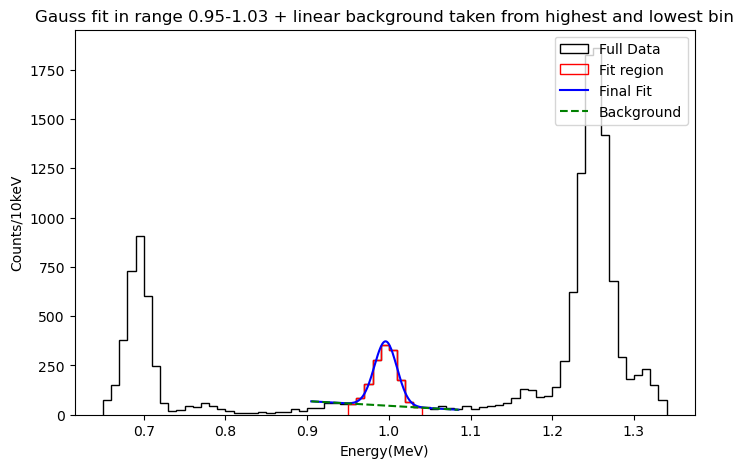

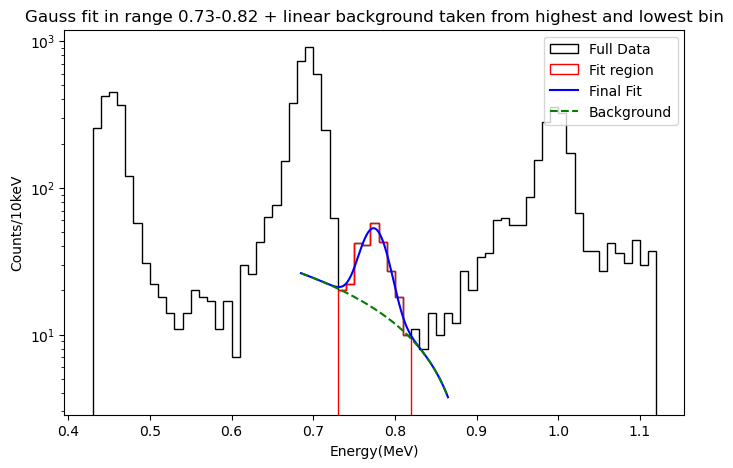

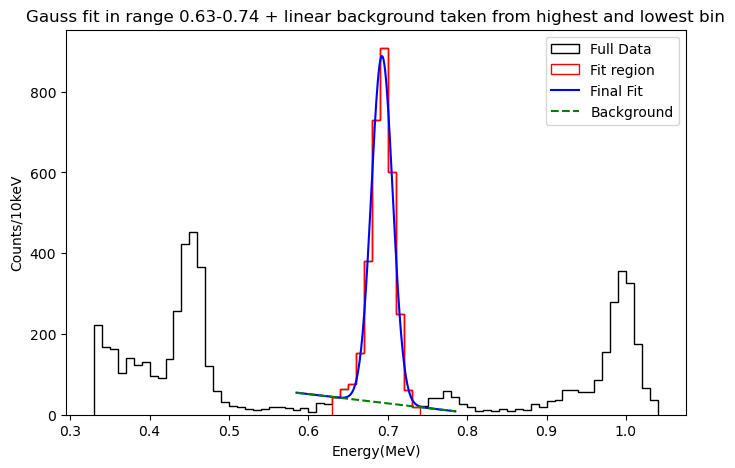

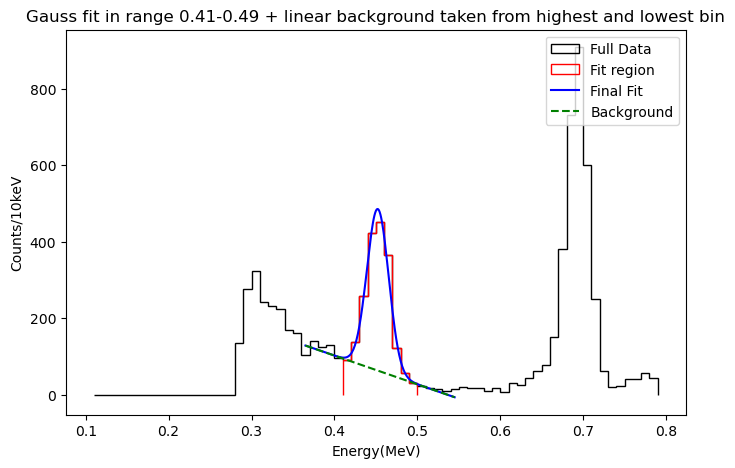

In [72]:
main = fixedlin_fit(E, 0.95, 1.03, gamma=1, quiet=False, yscale='linear')
main2 = fixedlin_fit(E, 0.73, 0.82, gamma=0, quiet=False, yscale='log')
main3 = fixedlin_fit(E, 0.63, 0.74, gamma=0, quiet=False, yscale='linear')
main4 = fixedlin_fit(E, 0.41, 0.49, gamma=1, quiet=False, yscale='linear')
